# Analysis of CLIP similarities on one movie

In [1]:
import sys
sys.path.append("/home/simon/mount/astranaar/moment_detr")
import os
from IPython.utils import io
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import TSNE
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA

import torch
from torch.nn import functional as F

from moment_detr.config import BaseOptions
from moment_detr.transformer import build_transformer
from moment_detr.position_encoding import build_position_encoding
from moment_detr.clip_similarity import clip_filter_proposals
from moment_detr.setup_clip_training import setup_training, set_seed, data_to_device
from moment_detr.clip_decoder_inference import sort_spans



In [2]:
with io.capture_output() as captured:
    opt = BaseOptions()
    opt.initialize()
    opt = opt.parse()
local_root = '/home/simon/data/'
remote_root = '/home/simon/mount/data/'

opt.train_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_train.json')
opt.eval_path_long_nlq = os.path.join(local_root, 'mad_dataset/annotations/MAD_test.json')
opt.eval_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_val.json')
opt.t_feat_dir = os.path.join(local_root, 'mad_dataset/')
opt.v_feat_dirs = [os.path.join(local_root, 'mad_dataset/')]
opt.resume = os.path.join(remote_root, 'mad_dataset/momentDETR_results/CLIP_L14_bsz128_lr4e-4_lrd15_dr1_wl30_smonline_fps5_lws4_lloss4_reduce_plateau/model_best.ckpt')
opt.concat_sims = False
opt.max_q_l = 100
opt.cuda_visible_devices=[0]

In [3]:
model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=0,use_clip_prefiltering=False)
dataloader = iter(train_loader)

batch = next(dataloader)
target, data, qid, windows = batch
clip_metrics = {}
_data, _target, windows, metrics, sims = clip_filter_proposals(data[0],target[0],7,300,clip_metrics,windows[0],-1)
movie = data[0]['src_vid']
topk_movie = _data['src_vid']
topk_target = _target

t = topk_target['is_foreground'].argmax().item()
rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]

start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[t])]
middle_frame = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])
start_end_frames = [_data['src_vid'][t][i] for i in start_end_relative_to_window]
middle_frame = _data['src_vid'][t][middle_frame]

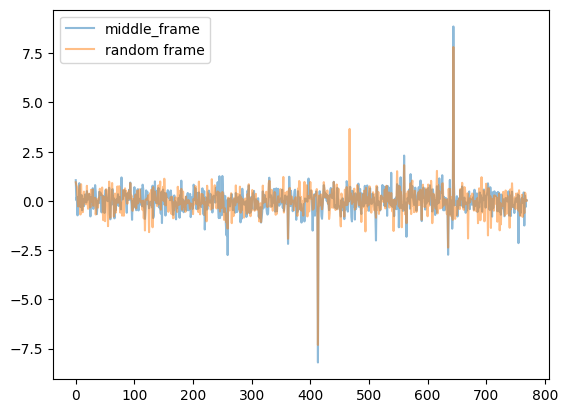

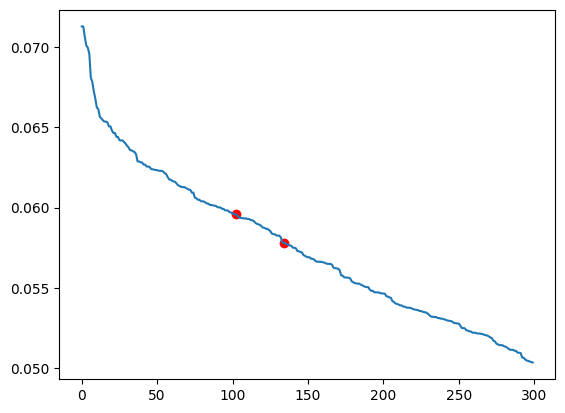

In [4]:
#labels = ['start frame','end frame', 'middle_frame', 'random frame']
labels = ['middle_frame', 'random frame']
for idx, frame in enumerate([middle_frame, _data['src_vid'][20][0]]):
    plt.plot(frame, label = labels[idx], alpha=0.5)
plt.legend(), plt.show()

plt.plot(sims)
for t in torch.where(topk_target['is_foreground']==1)[0]:
    plt.scatter(t, sims[t], c='red')
plt.show()

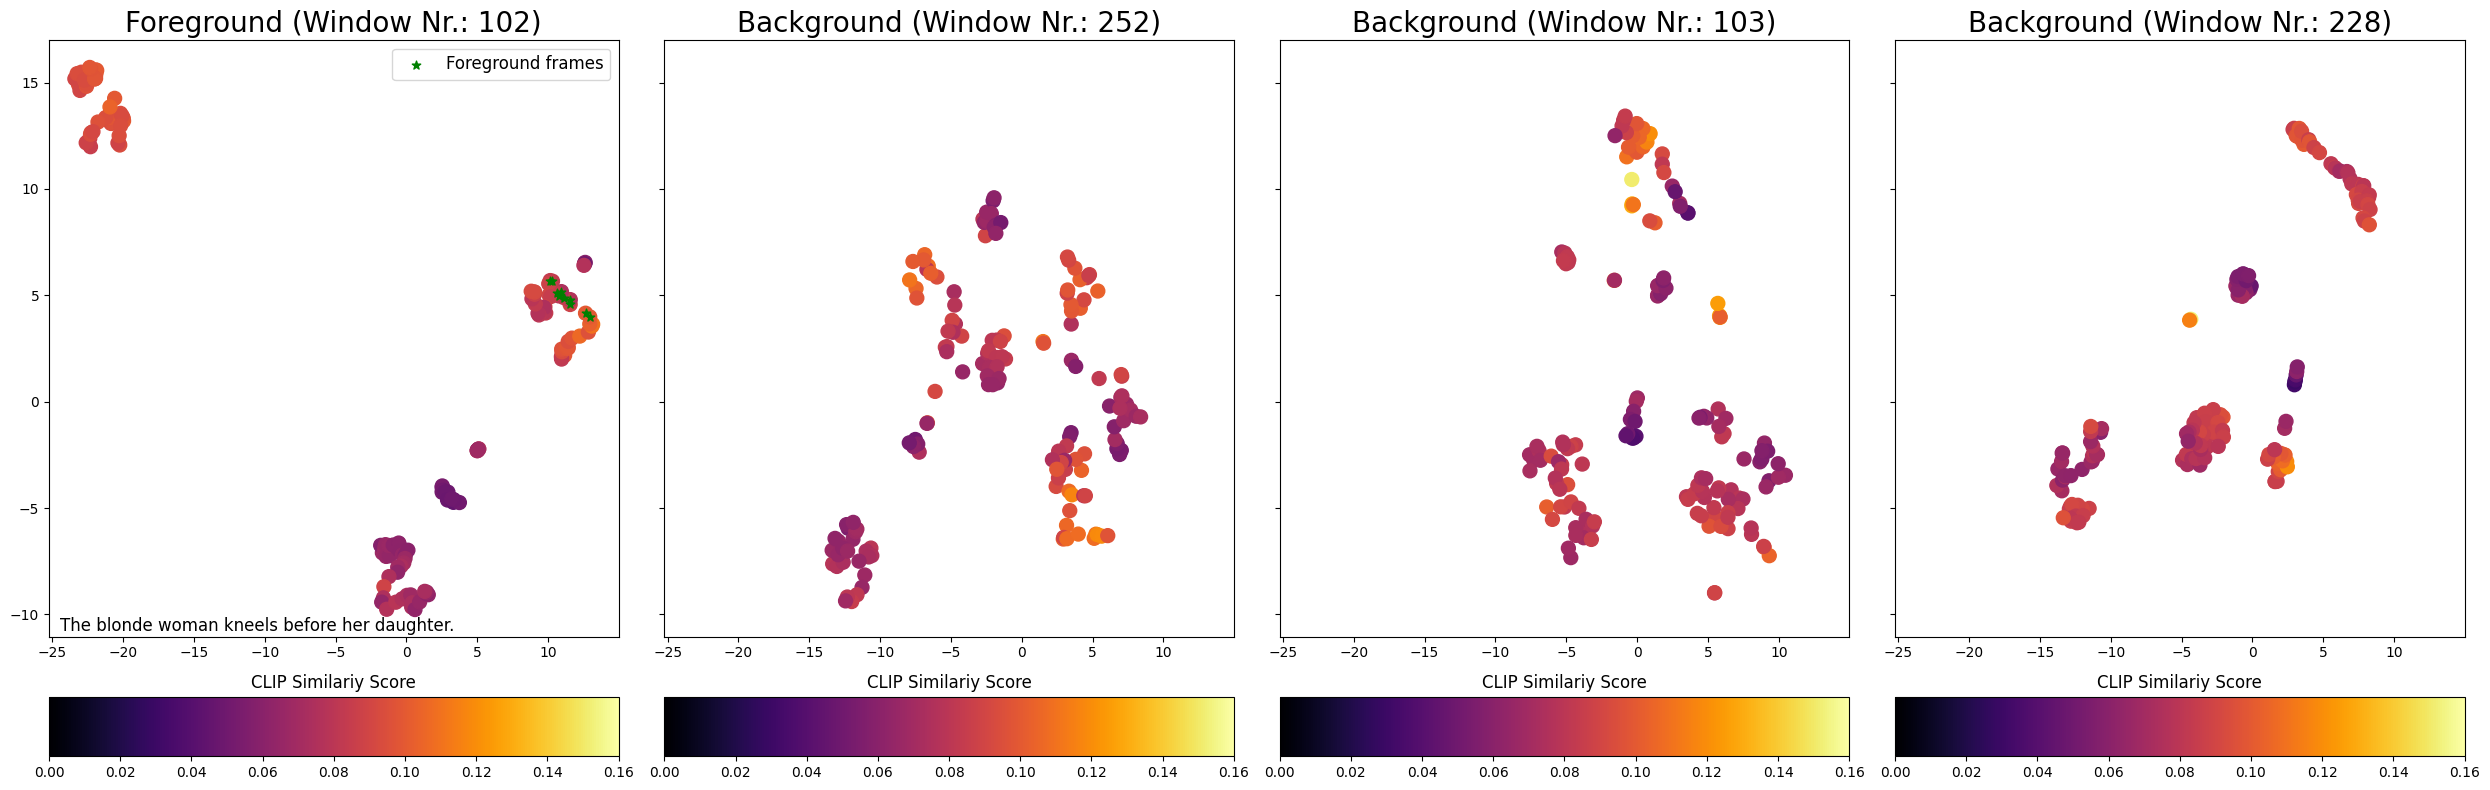

In [5]:
foreground_window_idx = topk_target['is_foreground'].argmax().item()
background_window_idx = [np.random.choice(torch.where(topk_target['is_foreground']==0)[0]) for _ in range(3)]

sentence = target[0]['anno']['sentence']
line_break = 10
words = sentence.split()
sentence = [words[i] + ('\n' if (i+1) % line_break == 0 else ' ') for i in range(len(words))]
sentence = ''.join(sentence)

tsne = TSNE(n_components=2)
pca = PCA(n_components=50)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 8), sharey=True, sharex=True)

for idx, ax, title in zip([foreground_window_idx] + background_window_idx, (ax1, ax2, ax3, ax4), ['Foreground']+['Background']*3):

    text = data[0]['src_txt'][idx,-1].unsqueeze(0)
    frames = data[0]['src_vid'][idx][...,:-2]
    sims = text @ frames.T
    sims = sims / sims.norm(dim=-1, keepdim=True)
    # sims.shape = (1,150)

    # Perform t-SNE on the flattened data
    with io.capture_output():
        movie_reduced = pca.fit_transform(topk_movie[idx])
        data_tsne = tsne.fit_transform(movie_reduced)

    # Plot the t-SNE output
    foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=sims, s=100, vmin=0, vmax=0.16, cmap='inferno')
    if title=='Foreground':
        data_fg = data_tsne[start_end_relative_to_window[0]:start_end_relative_to_window[1]]
        ax.scatter(data_fg[:, 0], data_fg[:, 1],marker='*',c='g', s=40, label = 'Foreground frames')
        ax.legend(fontsize=12)
        ax.text(0.02, 0.01, sentence, fontsize=12, transform=ax.transAxes)


    ax.set_title(f'{title} (Window Nr.: {idx})', fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='10%', pad=0.6)
    #cax.set_xlabel('data label')  # cax == cb.ax

    clb = plt.colorbar(foreground_dot, ax=ax, cax=cax, orientation='horizontal')
    clb.ax.set_title('CLIP Similariy Score',fontsize=12)

    
plt.tight_layout()


In [6]:
def load_batches():
    sentences = ['SOMEONE looks at SOMEONE', 'SOMEONE looking at SOMEONE', 'He looks at SOMEONE', 'She looks at SOMEONE']

    batches, clip_batches = [],[]
    for batch in tqdm(train_loader):
        target, data, qid, windows = batch
        if any([s in target[0]['anno']['sentence'] for s in sentences]):
            print('Sentence:' + target[0]['anno']['sentence'])
            clip_metrics = {}
            batches.append(batch)
            clip_batches.append(clip_filter_proposals(data[0],target[0],7,100,clip_metrics,windows[0],-1))
        if len(batches)==10:
            break



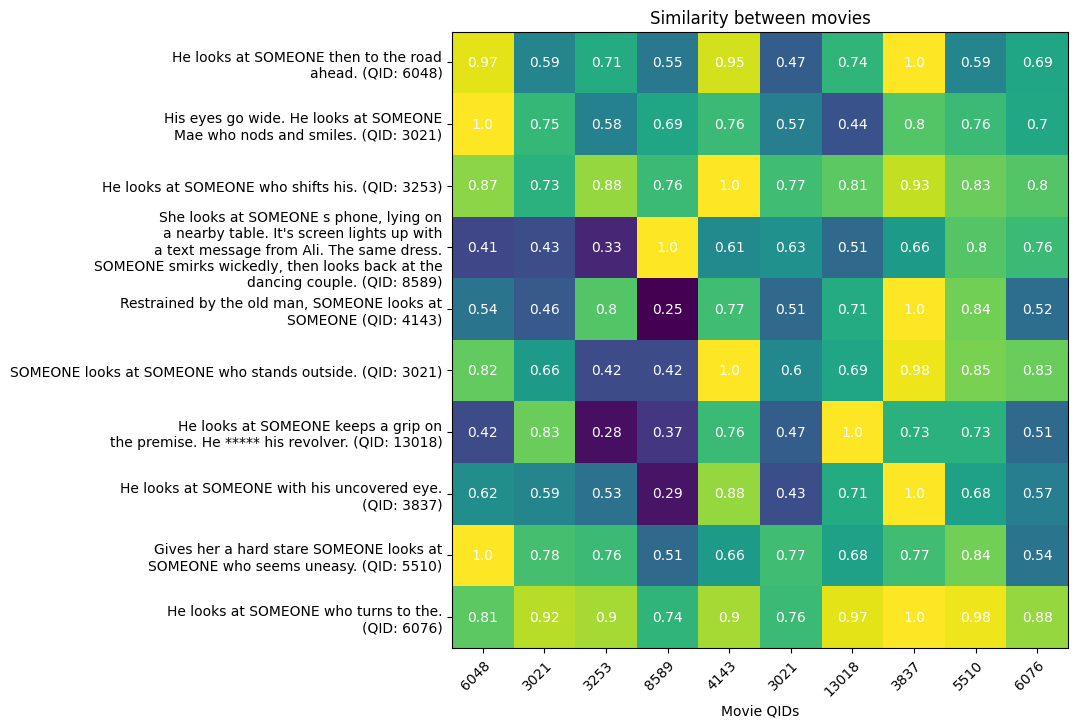

In [7]:
load_batches = True

if load_batches:
    with open(f'{local_root}notebooks/batches.pkl', 'rb') as f:
        batches = pickle.load(f)
else:
    batches, clip_batches = load_batches()


sentences = [b[0][0]["anno"]["sentence"] for b in batches]
movies = [b[0][0]["anno"]["movie"] for b in batches]

for sentence_idx, sentence in enumerate(sentences):
    line_break = 8
    words = sentence.split()
    sentence = [words[i] + ('\n' if (i+1) % line_break == 0 else ' ') for i in range(len(words))]
    sentences[sentence_idx] = ''.join(sentence)
    sentences[sentence_idx] += f'(QID: {movies[sentence_idx]})'


similarity, middle_frames, outer_frames = {}, [], []
for cnt, batch in enumerate(batches):

    batch_sims = []
    target, data, qid, windows = batch

    foreground_window_idx = target[0]['is_foreground'].argmax().item()
    text = data[0]["src_txt"][foreground_window_idx, -1].unsqueeze(0)


    for inner_data in batches:
        
        foreground_window_idx = inner_data[0][0]['is_foreground'].argmax().item()
        rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]
        start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[0][foreground_window_idx])]
        middle_frame_idx = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])

        inner_frames = inner_data[1][0]['src_vid'][foreground_window_idx][..., :-2]
        middle_frame = inner_frames[middle_frame_idx].unsqueeze(0)

        if cnt==0:
            middle_frames.append(middle_frame)
            outer_frames.append(inner_data[1][0]['src_vid'][50][0, :-2].unsqueeze(0))

        sims = text @ middle_frame.T
        batch_sims.append(sims.item())
    
    similarity[str(cnt)] = batch_sims

for key in similarity.keys():
    similarity[key] = [s / max(similarity[key]) for s in similarity[key]]


similarity = {k: [round(vv, 2) for vv in v] for k, v in similarity.items()}
fig, ax = plt.subplots(figsize=(8,8))

im = ax.imshow(np.array(list(similarity.values())))
ax.set_xticks(np.arange(len(similarity)))
ax.set_yticks(np.arange(len(similarity)))
ax.set_xticklabels(movies)
ax.set_yticklabels(sentences)
ax.set_xlabel('Movie QIDs')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
for i in range(len(similarity)):
    for j in range(len(similarity)):
        text = ax.text(j, i, similarity[list(similarity.keys())[i]][j],
                        ha="center", va="center", color="w")
ax.set_title("Similarity between movies")
plt.show()

#use topk mean pooling instead of middle frame


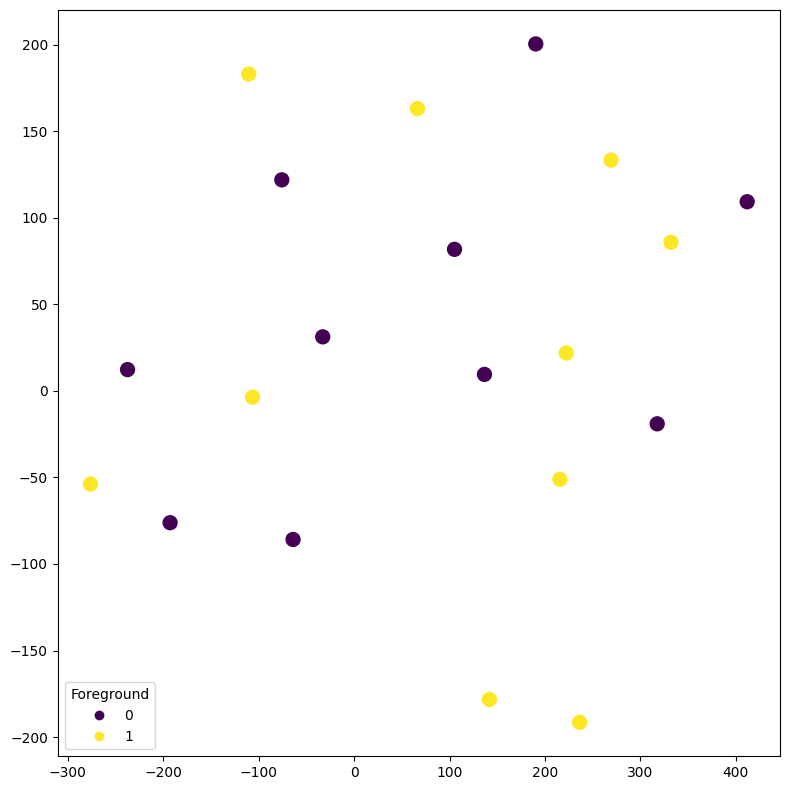

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

pca = PCA(n_components=20)

middle_frames_stacked = torch.cat(middle_frames,dim=0)
outer_frames_stacked = torch.cat(outer_frames,dim=0)
frames_stacked = torch.cat([middle_frames_stacked,outer_frames_stacked],dim=0)
inds = [1 for i in range(middle_frames_stacked.shape[0])] + [0 for i in range(outer_frames_stacked.shape[0])]

frames_stacked = pca.fit_transform(frames_stacked)

# Perform t-SNE on the flattened data
with io.capture_output():
    tsne = TSNE(n_components=2, perplexity = 10)
    data_tsne = tsne.fit_transform(frames_stacked)


# Plot the t-SNE results
foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap='viridis', s=100, c=inds)
#add legend
ax.legend(*foreground_dot.legend_elements(), loc="lower left", title="Foreground")
    
plt.tight_layout()

In [9]:
preds, targets = {}, {}

for batch in batches:
    target, data, qid, windows = batch
    print(target[0]['anno']['sentence'])
    data_on_gpu = data_to_device(batch[1], opt)
    outputs = model(**data_on_gpu[0])
    prob = F.softmax(outputs["pred_logits"], -1)[..., 0, None]
    spans = sort_spans(0, outputs, windows, prob)

    pred = np.vstack(np.array(spans))
    pred = pred[np.argsort(pred[:, -1])]
    pred = pred[::-1]
    preds[qid[0]] = pred
    targets[qid[0]] = target[0]['anno']['ext_timestamps']

He looks at SOMEONE  then to the road ahead.
His eyes go wide. He looks at SOMEONE Mae who nods and smiles.
He looks at SOMEONE who shifts his.
She looks at SOMEONE s phone, lying on a nearby table. It's screen lights up with a text message from Ali. The same dress. SOMEONE smirks wickedly, then looks back at the dancing couple.
Restrained by the old man, SOMEONE looks at SOMEONE 
 SOMEONE looks at SOMEONE  who stands outside.
He looks at SOMEONE  keeps a grip on the premise. He ***** his revolver.
He looks at SOMEONE with his uncovered eye.
Gives her a hard stare SOMEONE looks at SOMEONE  who seems uneasy.
He looks at SOMEONE  who turns to the.


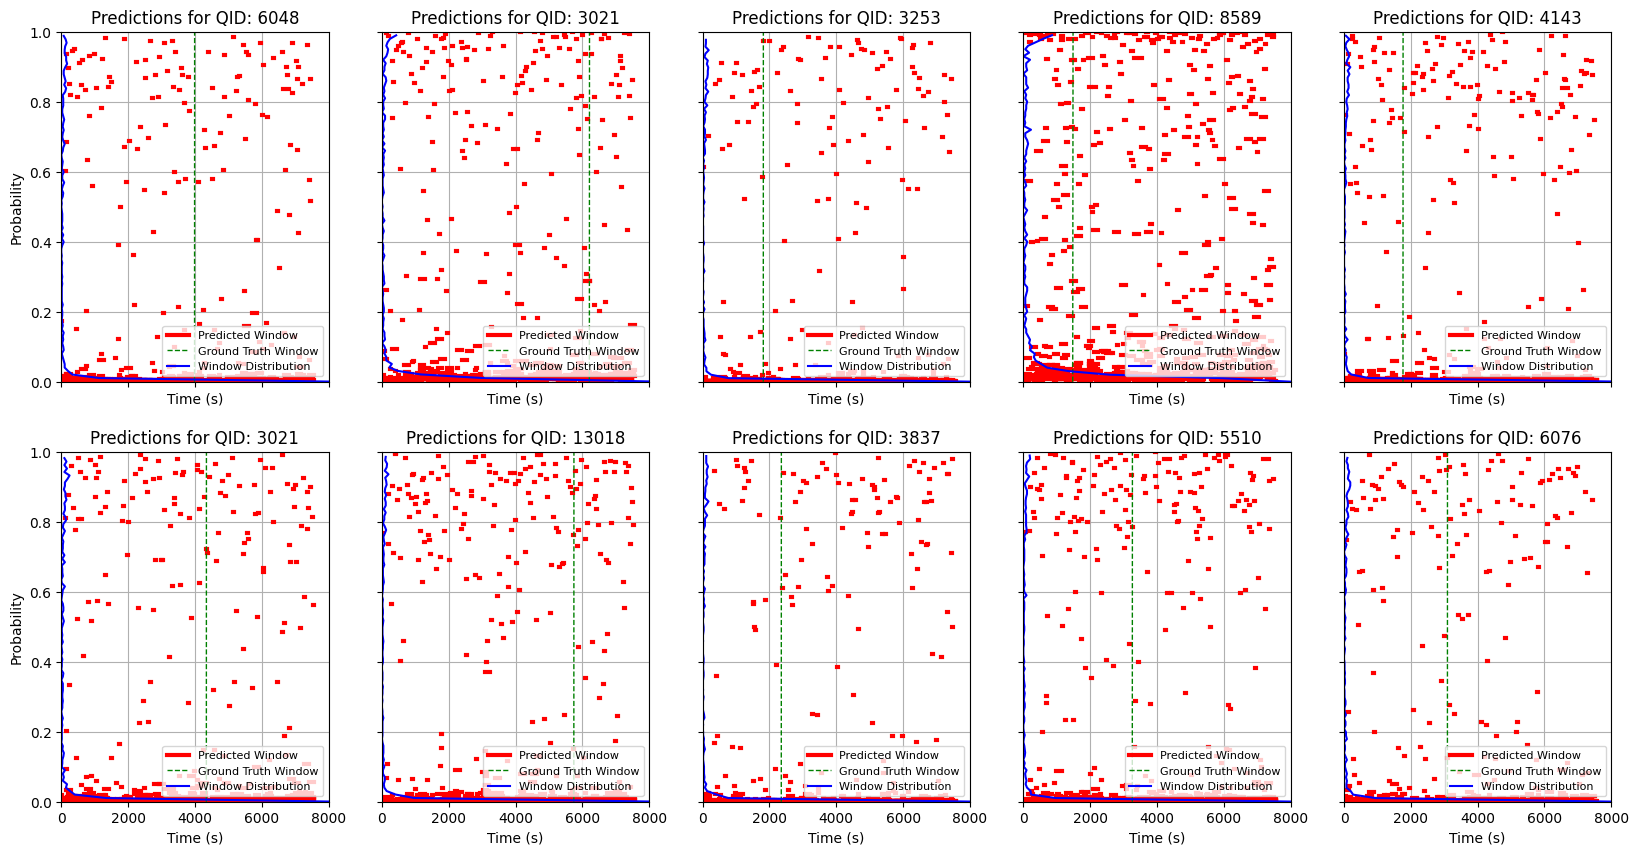

In [10]:
from scipy.stats import gaussian_kde
preds_iter = iter(preds.keys())

rows = 2
columns = 5
y_max = 8000
fig, ax = plt.subplots(2, 5, figsize=(20, 10),sharey=True,sharex=True)

for i in range(rows):
    for j in range(columns):
        key = next(preds_iter)
        span = preds[key]
        start_times = span[:,0]
        end_times = span[:,1]
        probs = span[:,2]

        cnt=0
        for s,e,p in zip(start_times,end_times,probs):
            if cnt==0:
                ax[i,j].plot([s,e], [p,p], color='red', linewidth=3, label='Predicted Window')
                cnt+=1
            else:
                ax[i,j].plot([s,e], [p,p], color='red', linewidth=3)

        ax[i,j].plot(targets[key],[0,1],'--',color='green',linewidth=1, label='Ground Truth Window')

        hist, edges = np.histogram(probs, bins=100)
        hist = (hist/hist.max())*y_max
        ax[i,j].plot(hist, edges[:-1], color = "blue", label='Window Distribution')

        ax[i,j].set_title(f'Predictions for QID: {movies[i*columns+j]}')
        ax[i,j].set_xlabel('Time (s)')
        ax[i,0].set_ylabel('Probability')
        ax[i,j].set_ylim(0,1)
        ax[i,j].set_xlim(0,y_max)
        ax[i,j].grid()
        #put a small legend in the bottom right corner of each subplot
        ax[i,j].legend(loc='lower right', fontsize=8)

plt.show()

In [3]:
preds, targets, vids, texts = [],[], [], []

with io.capture_output():
    model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=0,use_clip_prefiltering=False,training_shuffle=False)

movie=None
first=True
cutoff = 320
model.eval()

with torch.no_grad():
    for batch in tqdm(train_loader):

        target, data, qid, windows = batch

        if movie == target[0]['anno']['movie'] or first:
            movie = target[0]['anno']['movie']
            #print(target[0]['anno'])

            data_on_gpu = data_to_device(data, opt)
            outputs = model(**data_on_gpu[0])
            prob = F.softmax(outputs["pred_logits"], -1)[..., 0, None]
            spans = sort_spans(0, outputs, windows, prob)

            pred = np.vstack(np.array(spans))
            pred = pred[np.argsort(pred[:, -1])]
            pred = pred[::-1]

            preds.append(pred)
            targets.append(target[0])

            foreground_window_idx = target[0]['is_foreground'].argmax().item()
            rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]
            start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[0][foreground_window_idx])]
            middle_frame_idx = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])

            vids.append(data[0]['src_vid'][foreground_window_idx][middle_frame_idx].cpu())
            texts.append(data[0]['src_txt'][foreground_window_idx].cpu())
            first=False
        else:
            break
        
#save preds, targets, vids, texts
with open(f'{local_root}notebooks/output_one_movie.pkl', 'wb') as f:
    pickle.dump([preds,targets,vids,texts], f)


2023-01-30 09:31:00.657:INFO:moment_detr.inference - setup model/optimizer/scheduler
2023-01-30 09:31:01.543:INFO:moment_detr.inference - CUDA enabled.
2023-01-30 09:31:01.558:INFO:moment_detr.inference - Load checkpoint from /home/simon/mount/data/mad_dataset/momentDETR_results/CLIP_L14_bsz128_lr4e-4_lrd15_dr1_wl30_smonline_fps5_lws4_lloss4_reduce_plateau/model_best.ckpt
2023-01-30 09:31:01.768:INFO:moment_detr.setup_clip_training - Model MomentDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, element

In [231]:
with open(f'{local_root}notebooks/output_one_movie.pkl', 'rb') as f:
    preds,targets,vids,texts = pickle.load(f)

#texts_stacked = torch.vstack([t.sum(dim=0) for t in texts])
#with io.capture_output():
#    pca = PCA(n_components=20)
#    tsne = TSNE(n_components=2, perplexity = 10)
#    texts_stacked = pca.fit_transform(texts_stacked)
#    data_tsne = tsne.fit_transform(texts_stacked)

In [108]:
def get_idx(c_scatter,data_tsne, xmin,xmax,ymin,ymax, counter, targets, blob_texts, idxs):
    xmax_idx = set(np.where(data_tsne[:, 0]<xmax)[0])
    xmin_idx = set(np.where(data_tsne[:, 0]>xmin)[0])
    ymax_idx = set(np.where(data_tsne[:, 1]<ymax)[0])
    ymin_idx = set(np.where(data_tsne[:, 1]>ymin)[0])
    idx = xmax_idx.intersection(xmin_idx).intersection(ymax_idx).intersection(ymin_idx)
    c_scatter[list(idx)] = counter
    blob_texts.append([targets[i]['anno']['sentence'] for i in idx])
    idxs.append(list(idx))
    return c_scatter, blob_texts, idxs

[[' SOMEONE guides the drone above the house, then down into the chimney.',
  'The drone cuts through flowers, then slices of pillow. It knocks statues of ducks off a ledge.',
  'The drone Knox wine bottles and glasses offer at it cuts through the top of a light fixture which shatters on the floor.',
  'The drone breaks a framed photo of SOMEONE  which reads Worlds best Son.',
  'Hey the drone flies out of his hand and into the air.',
  'Outside SOMEONE controls, the drone on his phone as it takes off in the brunette.'],
 ['Frat brother charges SOMEONE ducks sending the brother flying into a beer pong table.',
  'Dead next shoots paintballs at the other frat brothers who run and hide.',
  'Bro Yusuf Ahmed as large frat brother Everett Adams as scab leader Nevis unit Pan as scab.',
  'Benji steps away. The frat brother takes a hit from a bong. The boys watch.'],
 [' SOMEONE kneels in front of her.',
  ' SOMEONE turns to the cop.',
  'Grinning softly sore watches from the stairs.',
  'Th

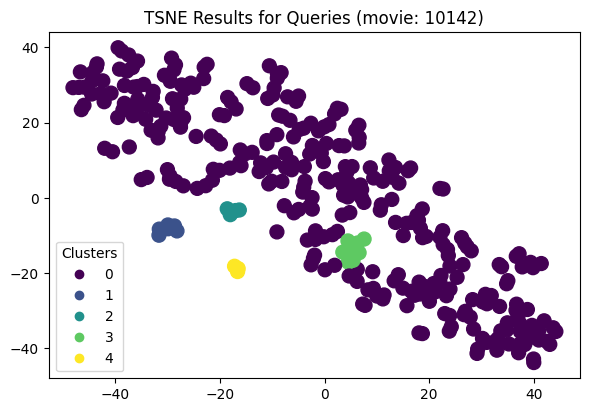

In [315]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

with open(f'{local_root}notebooks/data_tsne.pkl', 'rb') as f:
    data_tsne = pickle.load(f)

#blob_idx = set(np.where(data_tsne[:, 1]<-5)[0]).intersection(set(np.where(data_tsne[:, 0]<-25)[0]))
c_scatter = np.zeros(data_tsne.shape[0])
blob_texts, idxs = [], []
c_scatter,blob_texts,idxs = get_idx(c_scatter,data_tsne, -40,-20,-20,0, 1,targets,blob_texts,idxs)
c_scatter,blob_texts,idxs = get_idx(c_scatter,data_tsne, -20,-10,-10,0, 2,targets,blob_texts,idxs)
c_scatter,blob_texts,idxs = get_idx(c_scatter,data_tsne, 0,15,-17.5,-10, 3,targets,blob_texts,idxs)
c_scatter,blob_texts,idxs = get_idx(c_scatter,data_tsne, -20,-10,-25,-15, 4,targets,blob_texts,idxs)


foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap='viridis', s=100, c=c_scatter)
#add legend
ax.legend(*foreground_dot.legend_elements(), loc="lower left", title="Clusters")


plt.tight_layout()
plt.title(f"TSNE Results for Queries (movie: {targets[0]['anno']['movie']})")
blob_texts

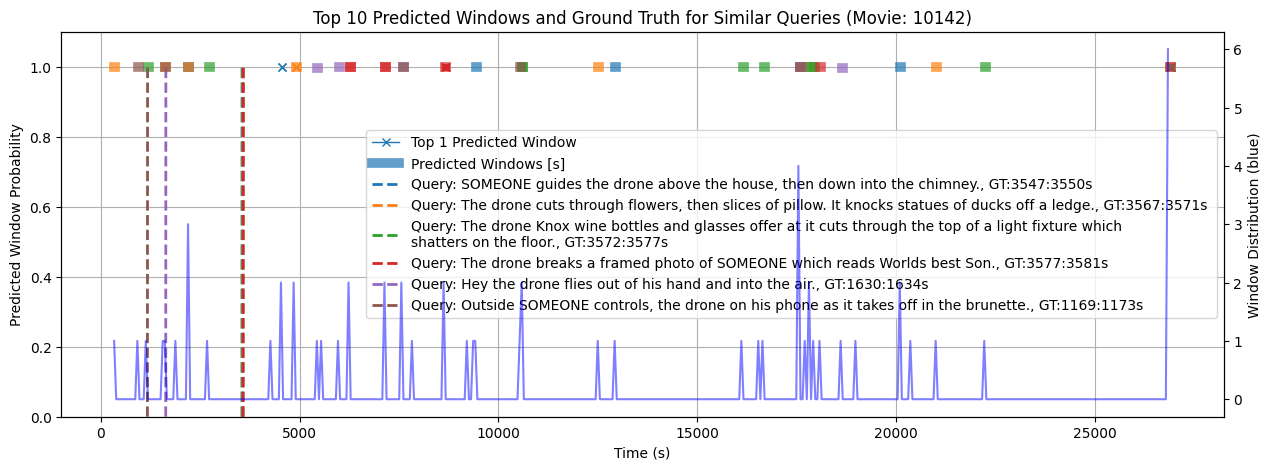

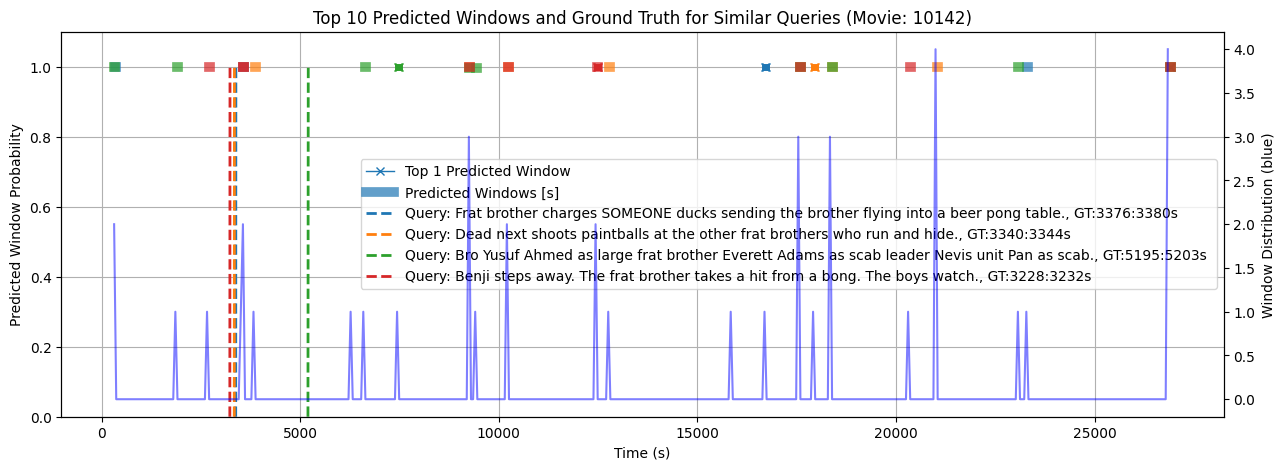

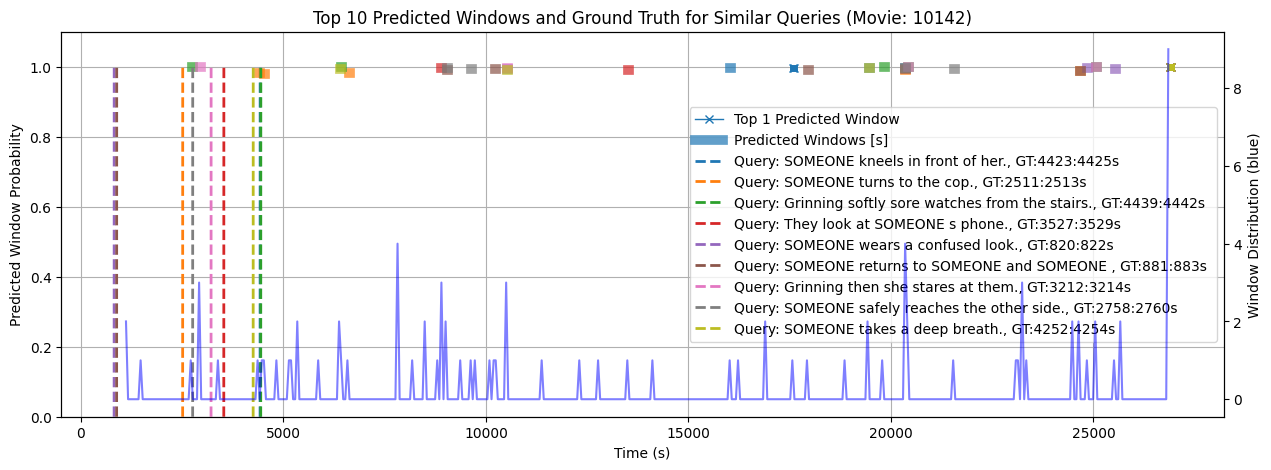

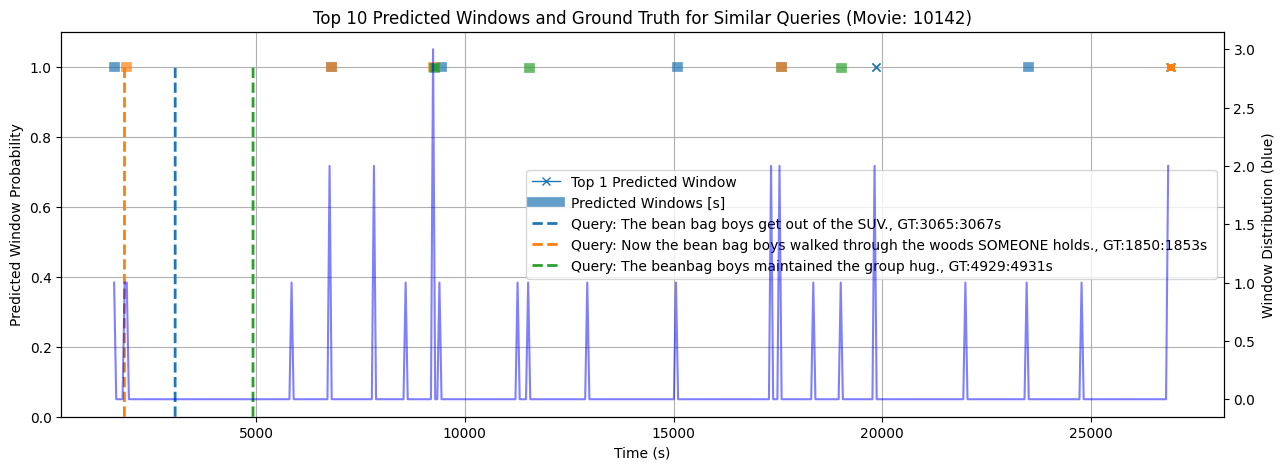

In [336]:
topk = 10

for blob_nr in range(4):
    blob_pred = [preds[i][:topk] for i in idxs[blob_nr]]
    blob_targets = [targets[i]['anno']['ext_timestamps'] for i in idxs[blob_nr]]
    blob_sentences = [targets[i]['anno']['sentence'] for i in idxs[blob_nr]]

    blob_pred[0].shape
    cols = iter(mcolors.TABLEAU_COLORS.values())

    rows = 1
    columns = 1
    y_max = 8000
    plt.figure(figsize=(15, 5))
    cnt_t = 0
    cnt_start=0
    line_break=20

    for span, tars, sentence in zip([preds[i][:10] for i in idxs[blob_nr]],[targets[i]['anno']['ext_timestamps'] for i in idxs[blob_nr]], blob_sentences):
        #span = preds[key]
        start_times = span[:,0]
        end_times = span[:,1]
        probs = span[:,2]
        color = next(cols)
        cnt=0
        #change plot colour for each span
        numbering = iter(range(topk))

        for s,e,p in zip(start_times,end_times,probs):
            if cnt==0:
                if cnt_start==0:
                    plt.plot([s,e], [p,p], color=color, linewidth=1, marker='x', label = 'Top 1 Predicted Window')
                    #plot an enumerating number onto the plot
                    cnt_start=1
                else:
                    plt.plot([s,e], [p,p], color=color, linewidth=5, marker='x')

                    cnt=1
            else:
                if cnt_t==0:
                    plt.plot([s,e], [p,p], color=color, linewidth=7, label = "Predicted Windows [s]", alpha=0.7)

                    cnt_t=1
                else:
                    plt.plot([s,e], [p,p], color=color, linewidth=7, alpha=0.7)


        words = (f'Query: {sentence}, GT:{round(tars[0])}:{round(tars[1])}s').split()
        sentence = [words[i] + ('\n' if (i+1) % line_break == 0 and (i+1)!=len(words) else ' ') for i in range(len(words))]
        sentence = ''.join(sentence)
        plt.plot(tars,[0,1],'--',color=color,linewidth=2, label=sentence)

    plt.xlabel('Time (s)')
    plt.ylabel('Predicted Window Probability')
    plt.legend(loc='center right')
    plt.title(f"Top 10 Predicted Windows and Ground Truth for Similar Queries (Movie: {targets[0]['anno']['movie']})")
    plt.ylim(0, 1.1) 
    plt.grid(True)

    ax2 = plt.twinx()
    hist, edges = np.histogram([preds[i][:10,0] for i in idxs[blob_nr]], bins=500)
    #hist = (hist/hist.max())
    ax2.plot(edges[:-1],hist, color = "blue", alpha=0.5)
    ax2.set_ylabel("Window Distribution (blue)")   
    plt.show()

In [340]:
opt.resume = os.path.join(remote_root, 'mad_dataset/momentDETR_results/CLIP_L14_bsz256_lr1e-4_dr1_wl30_fps5_lws4_lloss4_closs4_ret_tok_prop/model_best.ckpt')
opt.ret_tok = True
opt.decoder_gating_feature = 'ret_tok'
opt.ret_tok_prop=True
model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=0,use_clip_prefiltering=False,training_shuffle=False)


2023-01-30 14:29:34.077:INFO:moment_detr.inference - setup model/optimizer/scheduler
2023-01-30 14:29:34.152:INFO:moment_detr.inference - CUDA enabled.
2023-01-30 14:29:34.161:INFO:moment_detr.inference - Load checkpoint from /home/simon/mount/data/mad_dataset/momentDETR_results/CLIP_L14_bsz256_lr1e-4_dr1_wl30_fps5_lws4_lloss4_closs4_ret_tok_prop/model_best.ckpt
2023-01-30 14:29:34.377:INFO:moment_detr.setup_clip_training - Model MomentDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affin

Parameter Count: all 4,576,522; trainable 4,576,522


2023-01-30 14:29:36.642:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_language_tokens_features.h5
2023-01-30 14:29:36.643:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_frames_features_5fps.h5
2023-01-30 14:29:36.644:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/annotations/MAD_val.json
